<a href="https://colab.research.google.com/github/corvusMidnight/corvusMidnight/blob/main/2_(linear)_SGDClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn 

#Sampling
import imblearn
from imblearn.combine import SMOTETomek 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot
from numpy import where
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN

#Machine Learning algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

#Evaluation tools
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import make_scorer
from imblearn.metrics import geometric_mean_score
from sklearn.dummy import DummyClassifier

#Pipeline
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

#Pipeline visualization
from sklearn import set_config
from sklearn.utils import estimator_html_repr

#Pipeline display mode
set_config(display='diagram')


#Imputers
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

#Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

#OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

#Model tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold
#from tune_sklearn import TuneGridSearchCV
#from tune_sklearn import TuneSearchCV



#Ignore warnings
import warnings
from warnings import simplefilter

# Data

In [ ]:
#Loading the dataframe
url = 'https://raw.githubusercontent.com/corvusMidnight/ml_I-II/main/Datasets/final_dataframe_(df3).csv?token=GHSAT0AAAAAABNKWUMGONFOPTHZW4TFBH4UYPBKJSA'
df = pd.read_csv(url)

In [ ]:
#Dropping output NAs values
df = df[df['race'].notna()]

#Because LabelEncoder is not available anymore in sklearn for input variables and OneHotEncoder() cause serious runtime issues
#when ecnoding the 'neighborhood' column, the latter has been simply factorized.

df['neighborhood'] = pd.factorize(df.neighborhood)[0]
df['preRace'] = pd.factorize(df.preRace)[0] #Same as above

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df.head()

,Unnamed: 0,problem,personSearch,vehicleSearch,preRace,race,gender,lat,long,policePrecinct,neighborhood
0,2,Traffic Law Enforcement (P),1.0,1.0,0,White,2.0,44.948350,-93.275380,5.0,0
1,3,Suspicious Person (P),1.0,1.0,0,Non-white,1.0,44.948360,-93.281350,5.0,0
2,4,Traffic Law Enforcement (P),1.0,1.0,0,White,2.0,44.979078,-93.262076,1.0,1
3,5,Traffic Law Enforcement (P),1.0,1.0,0,Non-white,1.0,44.980535,-93.263627,1.0,1
4,6,Suspicious Person (P),1.0,1.0,0,Non-white,1.0,44.980808,-93.273141,1.0,1


In [ ]:
#NA values

df.isnull().sum()

Unnamed: 0          0
problem             0
personSearch        0
vehicleSearch       0
preRace             0
race                0
gender             45
lat                 0
long                0
policePrecinct    150
neighborhood        0
dtype: int64

In [ ]:
#Which columns are numerical? Which are categoricals?
numCols = df.select_dtypes("number").columns
catCols = df.select_dtypes("object").columns
numCols= list(set(numCols))
catCols= list(set(catCols))

print(f'Numerical columns: {numCols}')
print(f'Categorical columns: {catCols}')     

Numerical columns: ['vehicleSearch', 'long', 'personSearch', 'Unnamed: 0', 'preRace', 'neighborhood', 'lat', 'gender', 'policePrecinct']
Categorical columns: ['race', 'problem']


In [ ]:
imp_encoder_cols=[] #Columns that need both an imputer and an encoder
encoder_cols=[]     #Columns that only need the encoder

#For loop
for col in catCols:
    if df[col].isnull().sum() != 0:
        imp_encoder_cols.append(col)
    else:
        encoder_cols.append(col)
        
print(f'Columns that need an imputer and an encoder: {imp_encoder_cols}')
print(f'Columns that need OneHotEncoder: {encoder_cols}')


Columns that need an imputer and an encoder: []
Columns that need OneHotEncoder: ['race', 'problem']


# SGDClassifier

In [ ]:
#Model
sgd = SGDClassifier()
sgd.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#Input
X = df[['problem', 'vehicleSearch', 'preRace', 'personSearch', 'gender', 'policePrecinct', 'lat', 'long', 'neighborhood']]
y = df['race']


#Split

#Split into training and remaining data (70/30)
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=.26, shuffle=True, random_state=42)

#Split into test and validation data (15/15)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

#Shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_valid.shape, y_valid.shape

((53306, 9), (9365, 9), (53306,), (9365,), (9365, 9), (9365,))

In [ ]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72036 entries, 0 to 82294
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      72036 non-null  int64  
 1   problem         72036 non-null  object 
 2   personSearch    72036 non-null  float64
 3   vehicleSearch   72036 non-null  float64
 4   preRace         72036 non-null  int64  
 5   race            72036 non-null  object 
 6   gender          71991 non-null  float64
 7   lat             72036 non-null  float64
 8   long            72036 non-null  float64
 9   policePrecinct  71886 non-null  float64
 10  neighborhood    72036 non-null  int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 6.6+ MB
None
Unnamed: 0          0
problem             0
personSearch        0
vehicleSearch       0
preRace             0
race                0
gender             45
lat                 0
long                0
policePrecinct    150
neighborhood       

In [ ]:
#Preprocessors definitions
enc = OneHotEncoder()
imputer = KNNImputer()
lenc = LabelEncoder()
scaler1 = StandardScaler()
scaler2 = RobustScaler()

#Numerical values
#*Note*: some numeric variables are random binaries: i.e., binaries that indicate whether an event/condition
#happened or not). These features do not need scaling.
num_pre_1 = (imputer) #Columns that need only an imputer: policePrecinct, gender
num_pre_2 = (scaler1) #Columns that only need a scaler: long, lat

#Categorical values
#The only columns that needs an encoder, at this point, is the problem column.

#Preprocessor
preprocessor = make_column_transformer(
    (num_pre_1, ['policePrecinct', 'gender']),
    (num_pre_2, ['long', 'lat']),
    (OneHotEncoder(handle_unknown = 'ignore'), ['problem', 'preRace']),
    remainder='passthrough'
)

#pipeline
pipe = make_pipeline(preprocessor, sgd)
pipe.named_steps

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('knnimputer', KNNImputer(),
                                  ['policePrecinct', 'gender']),
                                 ('standardscaler', StandardScaler(),
                                  ['long', 'lat']),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore'),
                                  ['problem', 'preRace'])]),
 'sgdclassifier': SGDClassifier()}

In [ ]:
pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('knnimputer', KNNImputer(),
                                                  ['policePrecinct', 'gender']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['long', 'lat']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['problem', 'preRace'])])),
                ('sgdclassifier', SGDClassifier())])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

   Non-white       0.78      0.99      0.87      6388
       White       0.94      0.42      0.58      2977

    accuracy                           0.81      9365
   macro avg       0.86      0.70      0.73      9365
weighted avg       0.83      0.81      0.78      9365

0.8054065208419315


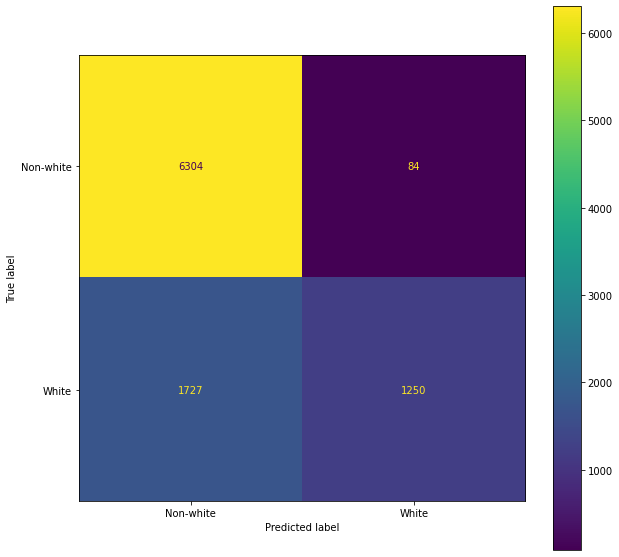

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(pipe, X_valid, y_valid, ax=ax);

y_valid_pred = pipe.predict(X_valid)
print(classification_report(y_valid, y_valid_pred))
print(pipe.score(X_train, y_train))

In [ ]:
#Is the dataset imbalanced?
df.race.value_counts()

Non-white    49530
White        22506
Name: race, dtype: int64

In [ ]:
#Note: in many cases, it is suggested to mix over and undersapmling techniques. Here, I test Overampling techniques (e.g., SMOTE)
# with some mixed technqiues
#Steps of the imbpipe

overtechniques = [SMOTE(), BorderlineSMOTE(), ADASYN()]
accuracies = []
#under = RandomUnderSampler()



for over in overtechniques:
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', over),
        ('classification', sgd)
    ])
    model.fit(X_train, y_train)
    y_valid_pred = model.predict(X_valid)
    print(f'The score is #{model.score(X_train, y_train)}')
    print('The accuracy for mode model is:', accuracy_score(y_valid, y_valid_pred))
    print('The f1 score for the model model is:',f1_score(y_valid, y_valid_pred, pos_label='Non-white'))

The score is #0.7989344539076276
The accuracy for mode model is: 0.800961025093433
The f1 score for the model model is: 0.8683429862974996
The score is #0.6970509886316737
The accuracy for mode model is: 0.7005872931126534
The f1 score for the model model is: 0.7655910382879118
The score is #0.5994259558023487
The accuracy for mode model is: 0.603950880939669
The f1 score for the model model is: 0.6029333047853549


In [ ]:
overtechniques = [SMOTE(), BorderlineSMOTE(), ADASYN()]
accuracies = []
under = RandomUnderSampler()



for over in overtechniques:
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', over),
        ('random_under_sampler', under),
        ('classification', sgd)
    ])
    model.fit(X_train, y_train)
    y_valid_pred = model.predict(X_valid)
    print(f'The score is #{model.score(X_train, y_train)}')
    print('The accuracy for mode model is:', accuracy_score(y_valid, y_valid_pred))
    print('The f1 score for the model model is:',f1_score(y_valid, y_valid_pred, pos_label='Non-white'))

The score is #0.7914306081866956
The accuracy for mode model is: 0.793272824345969
The f1 score for the model model is: 0.8618721461187213
The score is #0.6009454845608374
The accuracy for mode model is: 0.605125467164976
The f1 score for the model model is: 0.6054204011950491
The score is #0.7275353618729599
The accuracy for mode model is: 0.7279231179925254
The f1 score for the model model is: 0.8139331093909741


In [ ]:
over = OneSidedSelection()
under = RandomUnderSampler()


model = Pipeline([
        ('preprocessor', preprocessor),
        ('over_sampler', over),
        ('random_under_sampler', under),
        ('classification', sgd)
    ])

In [ ]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('knnimputer', KNNImputer(),
                                                  ['policePrecinct', 'gender']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['long', 'lat']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['problem', 'preRace'])])),
                ('over_sampler', OneSidedSelection()),
                ('random_under_sampler', RandomUnderSampler()),
                ('classification', SGDClassifier())])

### Hyperparameters tuning

In [ ]:
#Ration majority/minority class in training data
y_train.value_counts()

#Engineering a g-mean score for evaluation of the imbalanced data set (g-mean accounts for specificity and sensitivity,
#f1_macro doesn't)
gm_scorer = make_scorer(geometric_mean_score, greater_is_better=True, average='binary', pos_label='Non-white')


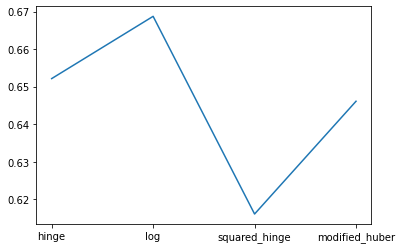

In [ ]:
accuracies, params = [], []

for n in ["hinge", "log", "squared_hinge", "modified_huber"]:
    params.append(n)
    sgd = SGDClassifier(loss=n)
    over = SMOTE()
    under = RandomUnderSampler()
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('over_sampler', over),
        ('random_under_sampler', under),
        ('classification', sgd)
    ])
    scores = cross_val_score(model, X_valid, y_valid, cv=StratifiedKFold(n_splits=3), scoring=gm_scorer)
    accuracies.append(scores.mean())
plt.plot(params, accuracies)
plt.show()

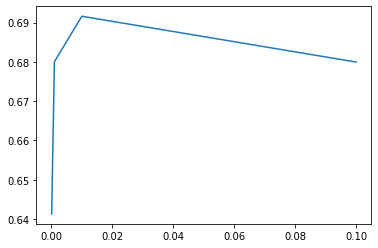

In [ ]:
accuracies, params = [], []

for alpha in [0.0001, 0.001, 0.01, 0.1]:
    params.append(alpha)
    sgd = SGDClassifier(alpha=alpha)
    over = SMOTE()
    under = RandomUnderSampler()
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('over_sampler', over),
        ('random_under_sampler', under),
        ('classification', sgd)
    ])
    scores = cross_val_score(model, X_valid, y_valid, cv=StratifiedKFold(n_splits=3), scoring=gm_scorer)
    accuracies.append(scores.mean())
plt.plot(params, accuracies)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

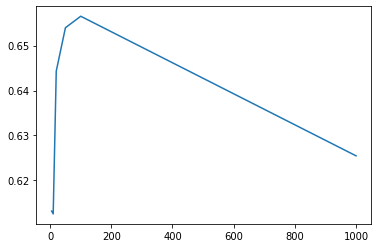

In [ ]:
accuracies, params = [], []

for n_iter in [5, 10, 20, 50, 100, 1000]:
    params.append(n_iter)
    sgd = SGDClassifier(max_iter=n_iter)
    over = SMOTE()
    under = RandomUnderSampler()
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('over_sampler', over),
        ('random_under_sampler', under),
        ('classification', sgd)
    ])
    scores = cross_val_score(model, X_valid, y_valid, cv=StratifiedKFold(n_splits=3), scoring=gm_scorer)
    accuracies.append(scores.mean())
plt.plot(params, accuracies)
plt.show()

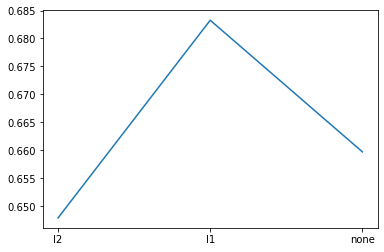

In [ ]:
accuracies, params = [], []

for penalty in ["l2", "l1", "none"]:
    params.append(penalty)
    sgd = SGDClassifier(penalty=penalty)
    over = SMOTE()
    under = RandomUnderSampler()
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('over_sampler', over),
        ('random_under_sampler', under),
        ('classification', sgd)
    ])
    scores = cross_val_score(model, X_valid, y_valid, cv=StratifiedKFold(n_splits=3), scoring=gm_scorer)
    accuracies.append(scores.mean())
plt.plot(params, accuracies)
plt.show()

In [ ]:
#Defining GridSearch
gs = GridSearchCV

#Tuning grid                           
grid = params = {
    "classification__loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "classification__alpha" : [0.0001, 0.001, 0.01, 0.1],
    "classification__penalty" : ["l2", "l1", "none"]
}

In [ ]:
gs_model = gs(estimator=model, param_grid=grid , cv=StratifiedKFold(n_splits=3), n_jobs=-1, verbose=1, refit=True)
display(gs_model)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('knnimputer',
                                                                         KNNImputer(),
                                                                         ['policePrecinct',
                                                                          'gender']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['long',
                                                                          'lat']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['problem',
                                                                          'preRace'])])),
                                       ('over_sampler', SMOTE()),
                                       ('random_under_sampler',
                                        RandomUnderSampler()),
                                       ('classification',
                                        SGDClassifier(penalty='none'))]),
             n_jobs=-1,
             param_grid={'classification__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'classification__loss': ['hinge', 'log',
                                                  'squared_hinge',
                                                  'modified_huber'],
                         'classification__penalty': ['l2', 'l1', 'none']},
             verbose=1)

In [ ]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'over_sampler', 'random_under_sampler', 'classification', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__knnimputer', 'preprocessor__standardscaler', 'preprocessor__onehotencoder', 'preprocessor__knnimputer__add_indicator', 'preprocessor__knnimputer__copy', 'preprocessor__knnimputer__metric', 'preprocessor__knnimputer__missing_values', 'preprocessor__knnimputer__n_neighbors', 'preprocessor__knnimputer__weights', 'preprocessor__standardscaler__copy', 'preprocessor__standardscaler__with_mean', 'preprocessor__standardscaler__with_std', 'preprocessor__onehotencoder__categories', 'preprocessor__onehotencoder__drop', 'preprocessor__onehotencoder__dtype', 'preprocessor__onehotencoder__handle_unknown', 'preprocessor__onehotencoder__sparse', 'over_sample

In [ ]:
gs_model.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('knnimputer',
                                                                         KNNImputer(),
                                                                         ['policePrecinct',
                                                                          'gender']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['long',
                                                                          'lat']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['problem',
                                                                          'preRace'])])),
                                       ('over_sampler', SMOTE()),
                                       ('random_under_sampler',
                                        RandomUnderSampler()),
                                       ('classification',
                                        SGDClassifier(penalty='none'))]),
             n_jobs=-1,
             param_grid={'classification__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'classification__loss': ['hinge', 'log',
                                                  'squared_hinge',
                                                  'modified_huber'],
                         'classification__penalty': ['l2', 'l1', 'none']},
             verbose=1)

In [ ]:
print(gs_model.best_params_)
print(gs_model.best_score_)
print(gs_model.best_estimator_)

{'classification__alpha': 0.1, 'classification__loss': 'hinge', 'classification__penalty': 'l1'}
0.8054064738983108
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('knnimputer', KNNImputer(),
                                                  ['policePrecinct', 'gender']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['long', 'lat']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['problem', 'preRace'])])),
                ('over_sampler', SMOTE()),
                ('random_under_sampler', RandomUnderSampler()),
                ('classification', SGDClassifier(alpha=0.1, penalty='l1'))])


In [ ]:
y_valid_pred = gs_model.predict(X_valid)


print(f'The score is #{gs_model.score(X_valid, y_valid)}')
print('The accuracy for mode model is:', accuracy_score(y_valid, y_valid_pred))
print('The f1 score for the model model is:',f1_score(y_valid, y_valid_pred, pos_label='Non-white'))

The score is #0.807261078483716
The accuracy for mode model is: 0.807261078483716
The f1 score for the model model is: 0.8753022452504317


### Cross-validation

In [ ]:
#Cross validation on the model with the best parameters

sgd = SGDClassifier(alpha=0.1, penalty='l1')
over = SMOTE()
under = RandomUnderSampler()

tuned_model = Pipeline([
              ('preprocessor', preprocessor),
              ('over_sampler', over),
              ('random_under_sampler', under),
              ('classification', sgd)
    ])

scores = cross_val_score(tuned_model, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring=gm_scorer)
scores

array([0.63445375, 0.63678325, 0.63313868, 0.63416154, 0.6231767 ])

### DummyClassifierComparison

In [ ]:
dummy1 = DummyClassifier(strategy="most_frequent")
dummy2 = DummyClassifier(strategy="stratified")

In [ ]:
dummy1.fit(X_train, y_train)
dummy1.score(X_train, y_train)

0.6875773834089971

In [ ]:
dummy2.fit(X_train, y_train)
dummy2.score(X_train, y_train)

0.5662026788729224

### Result on test data

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

   Non-white       0.79      0.99      0.88      6457
       White       0.93      0.42      0.58      2908

    accuracy                           0.81      9365
   macro avg       0.86      0.70      0.73      9365
weighted avg       0.83      0.81      0.78      9365

0.8054065208419315


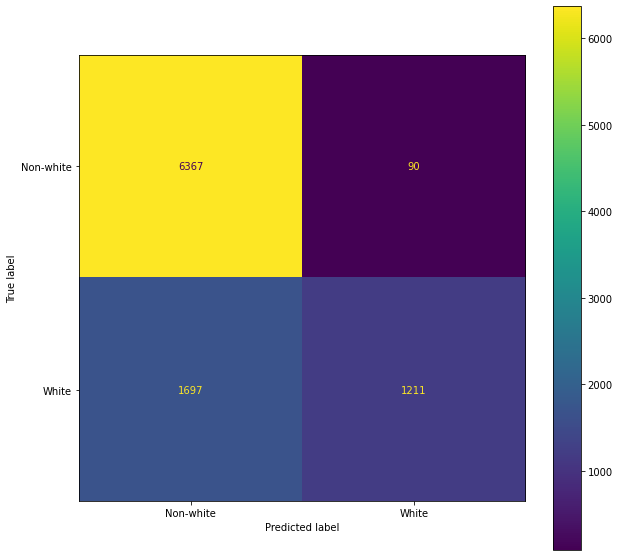

In [ ]:
tuned_model.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(tuned_model, X_test, y_test, ax=ax);

y_valid_pred = tuned_model.predict(X_test)
print(classification_report(y_test, y_valid_pred))
print(tuned_model.score(X_train, y_train))

### Learning and validation curves

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(estimator=tuned_model, X=X_train, y=y_train, cv=StratifiedKFold(n_splits=3))

In [ ]:
test_scores

array([[0.80550397, 0.80781136, 0.8029041 ],
       [0.80550397, 0.80781136, 0.8029041 ],
       [0.80550397, 0.80781136, 0.8029041 ],
       [0.80550397, 0.80781136, 0.8029041 ],
       [0.80550397, 0.80781136, 0.8029041 ]])

In [ ]:
train_mean = np.mean(train_scores, axis=1) # we want the column mean, so axis=1
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
print(train_mean, train_std, test_mean, test_std)

[0.80851862 0.80771784 0.80719707 0.80706341 0.8054047 ] [0.00583783 0.00065308 0.00090019 0.00075836 0.001     ] [0.80540647 0.80540647 0.80540647 0.80540647 0.80540647] [0.00200457 0.00200457 0.00200457 0.00200457 0.00200457]


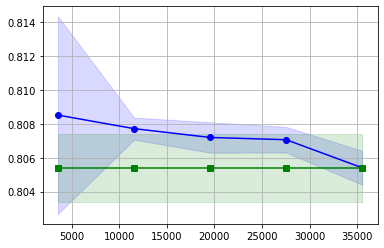

In [ ]:
plt.plot(train_sizes, train_mean, color='blue', marker='o')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.show()


In [ ]:
param_range = [0.0001, 0.001, 0.01, 0.1]
train_scores, test_scores = validation_curve(estimator=tuned_model, X=X_train, y=y_train, param_name='classification__alpha', param_range=param_range, cv=StratifiedKFold(n_splits=3))

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
print(train_mean, train_std, test_mean, test_std)

[0.79007038 0.72971152 0.75976449 0.80540651] [0.01628991 0.02418976 0.03348384 0.00100227] [0.78856066 0.7295988  0.76010176 0.80540647] [0.01868449 0.02358068 0.03264579 0.00200457]


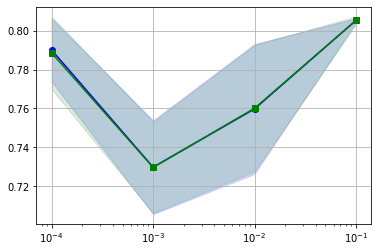

In [ ]:
plt.plot(param_range, train_mean, color='blue', marker='o')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', marker='s')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.show()
